## Project 5: WAM News Prediction of  California's Gubernatorial 2021 Election

## Import Libraries

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import metrics
# keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Recall
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# set random seed
import random
random.seed=42

## Load Data

In [2]:
# read data
df=pd.read_csv('./data/2018_gov_clean1.csv', index_col=0)
df.head()

,dist,ownhome,pid3,gender,age,educ,race,faminc,marstat,newsint,approval_gov,ideo5,voted_gov
392782,19,Other,Democrat,Female,54,4-Year,White,50k - 60k,Single / Never Married,Most of the time,Strongly Approve,Liberal,1
392786,52,Rent,Democrat,Female,28,Some College,White,20k - 30k,Single / Never Married,Most of the time,Strongly Approve,Liberal,1
392800,49,Own,Other,Male,86,Post-Grad,White,120k - 150k,Widowed,Most of the time,Strongly Disapprove,Very Conservative,0
392832,36,Own,Republican,Male,80,Some College,White,20k - 30k,Widowed,Most of the time,Strongly Disapprove,Conservative,0
392860,36,Own,Independent,Male,83,4-Year,White,Prefer not to say,Married,Most of the time,Strongly Disapprove,Conservative,0


In [3]:
# check for null values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3663 entries, 392782 to 452724
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   dist          3663 non-null   int64 
 1   ownhome       3663 non-null   object
 2   pid3          3663 non-null   object
 3   gender        3663 non-null   object
 4   age           3663 non-null   int64 
 5   educ          3663 non-null   object
 6   race          3663 non-null   object
 7   faminc        3663 non-null   object
 8   marstat       3663 non-null   object
 9   newsint       3663 non-null   object
 10  approval_gov  3663 non-null   object
 11  ideo5         3663 non-null   object
 12  voted_gov     3663 non-null   int64 
dtypes: int64(3), object(10)
memory usage: 400.6+ KB


In [4]:
# baseline accuracy
df.voted_gov.value_counts(normalize=True)

1    0.624352
0    0.375648
Name: voted_gov, dtype: float64

# Modeling

In [5]:
# set up X and y
X = df.drop(columns =['voted_gov'])
y = df['voted_gov']

In [6]:
# dummify X variable
X = pd.get_dummies(X, drop_first=True)

In [7]:
# checkout X shape
X.shape

(3663, 51)

In [8]:
# check if shape of X = y
assert X.shape[0]==y.shape[0]

In [9]:
# # split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

### 2. Neural Nets GridSearch

In [10]:
# # scale data
# sc = StandardScaler()
# X_train_sc = sc.fit_transform(X_train)
# X_test_sc = sc.transform(X_test)

In [11]:
# # Function to create model, required for KerasClassifier
# def create_model():
#     # create model
#     model = Sequential()
#     model.add(Dense(32, input_shape=(51,), activation='relu'))
#     model.add(Dense(32, activation='relu'))
#     model.add(Dense(1, activation='sigmoid')) 
#     # Compile model
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['Accuracy', 'Recall'])
#     return model

# # fix random seed for reproducibility
# seed = 7
# np.random.seed(seed)
# # early stopping
# early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
# # create model
# model = KerasClassifier(build_fn=create_model, verbose=0)

# # define the grid search parameters
# params_grid = {
#     'batch_size': [10, 20, 40, 60, 80, 100],
#     'epochs': [10, 50, 100],
# }

# gs_deep = GridSearchCV(model, param_grid=params_grid, cv=3, n_jobs=-1)
# gs_deep.fit(
#     X_train_sc, 
#     y_train, 
#     callbacks=early_stop, 
#     validation_data=(X_test_sc, y_test))
# print(gs_deep.best_params_)
# gs_deep.best_score_

In [12]:
# # Make predictions 
# preds_deep = gs_deep.predict(X_test_sc)

In [13]:
# ## classification report
# print(classification_report(y_test, preds_deep))

In [14]:


# # save confusion matrix values
# tn, fp, fn, tp = confusion_matrix(y_test, preds_deep).ravel()

In [15]:
# # save confusion matrix values
# tn, fp, fn, tp = confusion_matrix(y_test, preds_deep).ravel()
# # metrics
# accu = (tp+tn) / (tp+tn+fp+fn)
# recall = tp/(tp+fn)
# prec = tp/ (tp+fp)
# spec= tn/(tn+fp)

# print('Accuracy:', accu)
# print('Recall:', recall)
# print('Precision:', prec)
# print('Specificity:', spec)

### 2. Neural Net Classification - Early stopping

In [16]:
# set a random seed
tf.random.set_seed(1234)

In [17]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [18]:
# scale data
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [19]:
# create model with one hidden layer
model_nn1 = Sequential()
model_nn1.add(Dense(32, input_shape=(X_train_sc.shape[1],), activation='relu'))
model_nn1.add(Dense(1, activation='sigmoid'))

In [20]:
model_nn1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                1664      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,697
Trainable params: 1,697
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Compile it
model_nn1.compile(loss='bce', optimizer='adam', metrics=['Accuracy', 'Recall', 'Precision'])

In [22]:
# set early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [23]:
# fit model
history = model_nn1.fit(
    X_train_sc, y_train, 
    validation_data=(X_test_sc, y_test), 
    epochs=100, 
    callbacks=[early_stop], 
    verbose=1,
    batch_size=32
)

Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 0.5085 - Accuracy: 0.7856 - recall: 0.9096 - precision: 0.7823 - val_loss: 0.3775 - val_Accuracy: 0.8821 - val_recall: 0.9458 - val_precision: 0.8754
Epoch 2/100
86/86 [==============================] - 0s 1ms/step - loss: 0.2941 - Accuracy: 0.9090 - recall: 0.9481 - precision: 0.9099 - val_loss: 0.2637 - val_Accuracy: 0.9214 - val_recall: 0.9580 - val_precision: 0.9195
Epoch 3/100
86/86 [==============================] - 0s 1ms/step - loss: 0.2176 - Accuracy: 0.9276 - recall: 0.9592 - precision: 0.9273 - val_loss: 0.2219 - val_Accuracy: 0.9181 - val_recall: 0.9493 - val_precision: 0.9219
Epoch 4/100
86/86 [==============================] - 0s 1ms/step - loss: 0.1852 - Accuracy: 0.9319 - recall: 0.9580 - precision: 0.9346 - val_loss: 0.2062 - val_Accuracy: 0.9236 - val_recall: 0.9493 - val_precision: 0.9298
Epoch 5/100
86/86 [==============================] - 0s 1ms/step - loss: 0.1689 - Accuracy: 0.9367 - recall:

In [24]:
# save history into a df
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,Accuracy,recall,precision,val_loss,val_Accuracy,val_recall,val_precision
0,0.508476,0.785584,0.909621,0.782347,0.377455,0.882096,0.945804,0.875405
1,0.294056,0.908992,0.948105,0.909905,0.263650,0.921397,0.958042,0.919463
2,0.217605,0.927557,0.959184,0.927283,0.221949,0.918122,0.949301,0.921902
3,0.185162,0.931926,0.958017,0.934585,0.206239,0.923581,0.949301,0.929795
4,0.168870,0.936658,0.963265,0.937039,0.198711,0.924672,0.942308,0.937391


In [87]:
history_df[10:]

,loss,Accuracy,recall,precision,val_loss,val_Accuracy,val_recall,val_precision
10,0.132158,0.947943,0.968513,0.949143,0.191629,0.934498,0.954545,0.941379
11,0.128971,0.947579,0.966181,0.950660,0.193440,0.934498,0.956294,0.939863
12,0.125504,0.951219,0.970845,0.951973,0.193061,0.932314,0.947552,0.944251
13,0.122216,0.951219,0.970262,0.952490,0.193612,0.930131,0.949301,0.939446
14,0.120048,0.953040,0.970262,0.955224,0.193153,0.936681,0.956294,0.943103


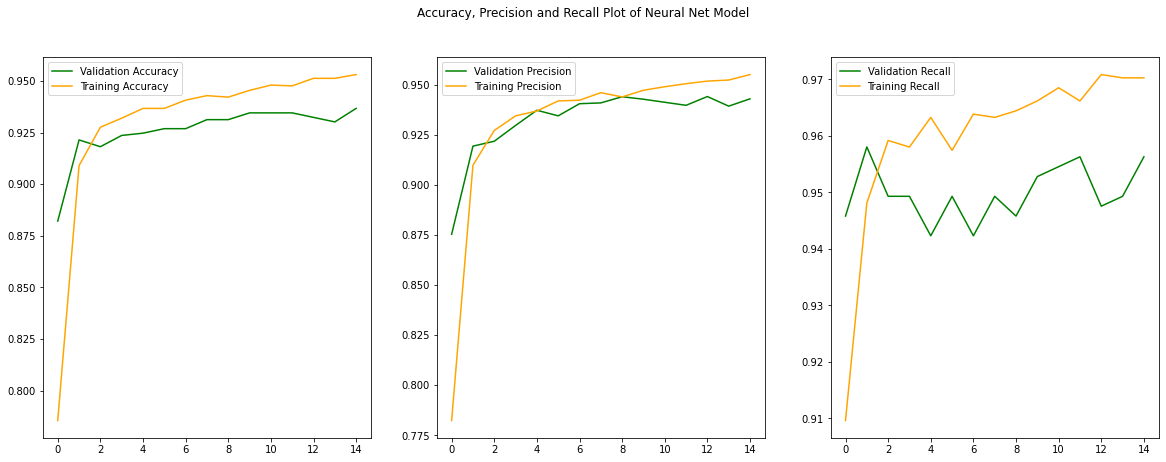

In [25]:
# subplots of accuracy, precision and recall
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols=3, figsize = (20, 7))
fig.suptitle('Accuracy, Precision and Recall Plot of Neural Net Model')

# axis 1
ax1.plot(history_df['val_Accuracy'], label='Validation Accuracy', color='green')
ax1.plot(history_df['Accuracy'], label='Training Accuracy', color='orange')
ax1.legend(loc="upper left")
# axis 2
ax2.plot(history_df['val_precision'], label='Validation Precision', color='green')
ax2.plot(history_df['precision'], label='Training Precision', color='orange')
ax2.legend(loc="upper left")
#axis3
ax3.plot(history_df['val_recall'], label='Validation Recall', color='green')
ax3.plot(history_df['recall'], label='Training Recall', color='orange')
ax3.legend(loc="upper right")

plt.legend();

The plots show that this model with one hidden layer and early stopping is slightly overfit. 

In [26]:
# evaluate model
model_nn1.evaluate(X_test_sc, y_test, verbose=2)

29/29 - 0s - loss: 0.1932 - Accuracy: 0.9367 - recall: 0.9563 - precision: 0.9431


[0.19315281510353088,
 0.9366812109947205,
 0.9562937021255493,
 0.9431034326553345]

In [27]:
# make predictions
y_pred_nn1=model_nn1.predict(X_test_sc)
y_pred_nn1[:10]

array([[0.7275185 ],
       [0.7263742 ],
       [0.00120929],
       [0.9989493 ],
       [0.47994626],
       [0.98545134],
       [0.9997022 ],
       [0.9999677 ],
       [0.01875579],
       [0.99897414]], dtype=float32)

In [28]:
# round predicted values
y_pred_nn1 =y_pred_nn1.round()
y_pred_nn1[:10]

array([[1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.]], dtype=float32)

In [29]:
# confusion matrix using Tensorflow
tf.math.confusion_matrix(
    y_test, y_pred_nn1
)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[311,  33],
       [ 25, 547]], dtype=int32)>

In [30]:
# classification report
print(classification_report(y_test, y_pred_nn1))

              precision    recall  f1-score   support

           0       0.93      0.90      0.91       344
           1       0.94      0.96      0.95       572

    accuracy                           0.94       916
   macro avg       0.93      0.93      0.93       916
weighted avg       0.94      0.94      0.94       916



On test data: 
- accuracy: 0.9108 
- recall: 0.8667 
- precision: 0.8925

On train data:
- accuracy: 0.9373 
- recall: 0.8888 
- precision: 0.9406

This model has an accuracy of 91% which improved the null model accuracy of 62%.  

In [31]:
# save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_nn1).ravel()
# metrics
accu = (tp+tn) / (tp+tn+fp+fn)
recall = tp/(tp+fn)
prec = tp/ (tp+fp)
spec= tn/(tn+fp)

print('Accuracy:', accu)
print('Recall:', recall)
print('Precision:', prec)
print('Specificity:', spec)

Accuracy: 0.9366812227074236
Recall: 0.9562937062937062
Precision: 0.9431034482758621
Specificity: 0.9040697674418605


### 3. Neural Net Classification - 2 hidden layers & dropout

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [33]:
# scale data
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [34]:
model_nn2 = Sequential()

In [35]:
# create model
model_nn2.add(Dense(32, input_shape=(X_train_sc.shape[1],), activation='relu'))
model_nn2.add(Dropout(0.2))
model_nn2.add(Dense(10, activation='relu'))
model_nn2.add(Dropout(0.2))
model_nn2.add(Dense(1, activation='sigmoid'))

In [36]:
# compile model
model_nn2.compile(loss='bce', optimizer ='adam', metrics = ['Accuracy', 'Recall', 'Precision'])

In [37]:
# fit model
history_2 = model_nn2.fit(
    X_train_sc,
    y_train,
    validation_data=(X_test_sc, y_test),
    epochs=100,
    verbose=0
)

In [38]:
# save history into a df
history_2_df = pd.DataFrame(history_2.history)
history_2_df.head()

,loss,Accuracy,recall,precision,val_loss,val_Accuracy,val_recall,val_precision
0,0.695043,0.586094,0.606997,0.692154,0.579397,0.751092,0.903846,0.749275
1,0.494738,0.783764,0.916035,0.777338,0.380851,0.852620,0.972028,0.823704
2,0.340514,0.856935,0.940525,0.847164,0.270758,0.901747,0.965035,0.887460
3,0.269882,0.898071,0.934111,0.905596,0.231794,0.919214,0.965035,0.910891
4,0.236185,0.912632,0.949854,0.913629,0.216868,0.930131,0.968531,0.923333


In [89]:
history_2_df.tail()

,loss,Accuracy,recall,precision,val_loss,val_Accuracy,val_recall,val_precision
95,0.059734,0.976338,0.988338,0.974138,0.448882,0.920306,0.944056,0.929432
96,0.061088,0.976338,0.988338,0.974138,0.441763,0.925764,0.951049,0.931507
97,0.051512,0.979978,0.990671,0.977560,0.458130,0.923581,0.949301,0.929795
98,0.063418,0.977794,0.990087,0.974742,0.448169,0.924672,0.951049,0.929915
99,0.056012,0.977066,0.991837,0.972000,0.458204,0.921397,0.945804,0.929553


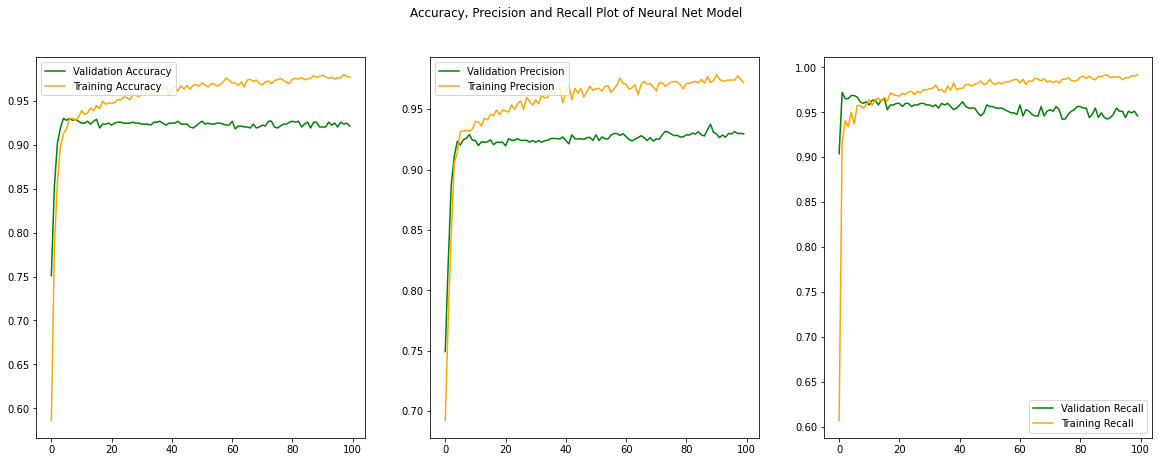

In [40]:
# subplots of accuracy, precision and recall
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols=3, figsize = (20, 7))
fig.suptitle('Accuracy, Precision and Recall Plot of Neural Net Model')

# axis 1 - accuracy
ax1.plot(history_2_df["val_Accuracy"], label='Validation Accuracy', color='green')
ax1.plot(history_2_df["Accuracy"], label='Training Accuracy', color='orange')
ax1.legend(loc="upper left")
# axis 2 - precision
ax2.plot(history_2_df['val_precision'], label='Validation Precision', color='green')
ax2.plot(history_2_df['precision'], label='Training Precision', color='orange')
ax2.legend(loc="upper left")
# axis3 - recall
ax3.plot(history_2_df['val_recall'], label='Validation Recall', color='green')
ax3.plot(history_2_df['recall'], label='Training Recall', color='orange')
ax3.legend(loc="upper right")

plt.legend();

In [41]:
# evaluate model
model_nn2.evaluate(X_test_sc, y_test, verbose=2)

29/29 - 0s - loss: 0.4582 - Accuracy: 0.9214 - recall: 0.9458 - precision: 0.9296


[0.45820382237434387,
 0.9213973879814148,
 0.9458041787147522,
 0.9295532703399658]

In [42]:
# make predictions
y_pred_nn2=model_nn2.predict(X_test_sc)
y_pred_nn2[:10]

array([[9.1722512e-01],
       [6.1837494e-01],
       [1.0368365e-16],
       [9.9987257e-01],
       [5.8383244e-01],
       [9.9651933e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [6.9377537e-10],
       [1.0000000e+00]], dtype=float32)

In [43]:
# round predicted values
y_pred_nn2 =y_pred_nn2.round()
y_pred_nn2[:10]

array([[1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.]], dtype=float32)

In [44]:
# confusion matrix using Tensorflow
tf.math.confusion_matrix(
    y_test, y_pred_nn2
)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[303,  41],
       [ 31, 541]], dtype=int32)>

In [45]:
# classification report
print(classification_report(y_test, y_pred_nn2))

              precision    recall  f1-score   support

           0       0.91      0.88      0.89       344
           1       0.93      0.95      0.94       572

    accuracy                           0.92       916
   macro avg       0.92      0.91      0.92       916
weighted avg       0.92      0.92      0.92       916



In [83]:
# save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_nn2).ravel()
# metrics
accu = (tp+tn) / (tp+tn+fp+fn)
recall = tp/(tp+fn)
prec = tp/ (tp+fp)
spec= tn/(tn+fp)

print('Accuracy:', accu)
print('Recall:', recall)
print('Precision:', prec)
print('Specificity:', spec)

Accuracy: 0.9213973799126638
Recall: 0.9458041958041958
Precision: 0.929553264604811
Specificity: 0.8808139534883721


### 4. Neural Net Classification - Early stopping & dropout

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [47]:
# scale data
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [48]:
model_nn3 = Sequential()

In [49]:
# create model
model_nn3.add(Dense(32, input_shape=(X_train_sc.shape[1],), activation='relu'))
model_nn3.add(Dropout(0.1))
model_nn3.add(Dense(32, activation='relu'))

# model_nn3.add(Dropout(0.1))
# model_nn3.add(Dense(32, activation='relu'))

model_nn3.add(Dense(1, activation='sigmoid'))

# 'dropout': 0.1, 'epochs': 10, 'hidden_layers': 2, 'hidden_neurons': 32

In [50]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [51]:
# compile model
model_nn3.compile(loss='bce', optimizer ='adam', metrics = ['Accuracy', 'Recall', 'Precision'])

In [52]:
# fit model
history_3 = model_nn3.fit(
    X_train_sc,
    y_train,
    validation_data=(X_test_sc, y_test),
    epochs=100,
    callbacks=early_stop,
    verbose=0
)

Epoch 00014: early stopping


In [53]:
# save history into a df
history_3_df = pd.DataFrame(history_3.history)
history_3_df.head()

,loss,Accuracy,recall,precision,val_loss,val_Accuracy,val_recall,val_precision
0,0.491144,0.783764,0.929446,0.771166,0.369105,0.866812,0.951049,0.852665
1,0.277741,0.894066,0.941691,0.894241,0.260267,0.909389,0.959790,0.901478
2,0.200549,0.924645,0.956851,0.925028,0.230293,0.920306,0.956294,0.919328
3,0.178145,0.929377,0.954519,0.933828,0.220651,0.926856,0.961538,0.924370
4,0.170153,0.932654,0.961516,0.932692,0.216088,0.927948,0.945804,0.939236


In [90]:
history_3_df.tail()

,loss,Accuracy,recall,precision,val_loss,val_Accuracy,val_recall,val_precision
9,0.131372,0.945759,0.964431,0.949483,0.216165,0.933406,0.954545,0.939759
10,0.127646,0.948671,0.965598,0.952819,0.219980,0.933406,0.963287,0.932318
11,0.123806,0.952312,0.967930,0.956221,0.224082,0.932314,0.961538,0.932203
12,0.126045,0.951584,0.965598,0.957225,0.224389,0.932314,0.958042,0.935154
13,0.111631,0.957408,0.974927,0.957617,0.227275,0.927948,0.949301,0.936207


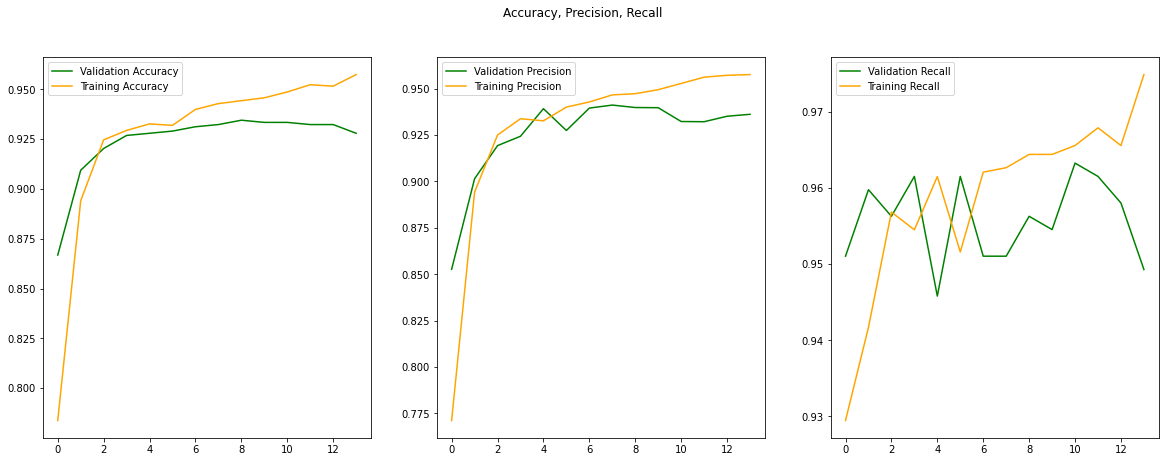

In [55]:
# subplots of accuracy, precision and recall
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols=3, figsize = (20, 7))
fig.suptitle('Accuracy, Precision, Recall')

# axis 1 - accuracy
ax1.plot(history_3_df["val_Accuracy"], label='Validation Accuracy', color='green')
ax1.plot(history_3_df["Accuracy"], label='Training Accuracy', color='orange')
ax1.legend(loc="upper left")
# axis 2 - precision
ax2.plot(history_3_df['val_precision'], label='Validation Precision', color='green')
ax2.plot(history_3_df['precision'], label='Training Precision', color='orange')
ax2.legend(loc="upper left")
# axis3 - recall
ax3.plot(history_3_df['val_recall'], label='Validation Recall', color='green')
ax3.plot(history_3_df['recall'], label='Training Recall', color='orange')
ax3.legend(loc="upper left")

plt.legend();

In [56]:
# evaluate model
model_nn3.evaluate(X_test_sc, y_test, verbose=2)

29/29 - 0s - loss: 0.2273 - Accuracy: 0.9279 - recall: 0.9493 - precision: 0.9362


[0.2272750437259674,
 0.9279475808143616,
 0.9493007063865662,
 0.9362068772315979]

In [57]:
# make predictions
y_pred_nn3=model_nn3.predict(X_test_sc)
y_pred_nn3[:10]

array([[8.8372457e-01],
       [6.5454471e-01],
       [7.4390475e-05],
       [9.9874723e-01],
       [8.8221824e-01],
       [9.7136867e-01],
       [9.9980366e-01],
       [9.9999851e-01],
       [3.6582351e-04],
       [9.9988329e-01]], dtype=float32)

In [58]:
# round predicted values
y_pred_nn3 =y_pred_nn3.round()
y_pred_nn3[:10]

array([[1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.]], dtype=float32)

In [59]:
# confusion matrix using Tensorflow
tf.math.confusion_matrix(
    y_test, y_pred_nn3
)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[307,  37],
       [ 29, 543]], dtype=int32)>

In [60]:
# classification report
print(classification_report(y_test, y_pred_nn3))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       344
           1       0.94      0.95      0.94       572

    accuracy                           0.93       916
   macro avg       0.92      0.92      0.92       916
weighted avg       0.93      0.93      0.93       916



In [84]:
# save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_nn3).ravel()
# metrics
accu = (tp+tn) / (tp+tn+fp+fn)
recall = tp/(tp+fn)
prec = tp/ (tp+fp)
spec= tn/(tn+fp)

print('Accuracy:', accu)
print('Recall:', recall)
print('Precision:', prec)
print('Specificity:', spec)

Accuracy: 0.9279475982532751
Recall: 0.9493006993006993
Precision: 0.9362068965517242
Specificity: 0.8924418604651163


5. Neural net

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [62]:
# scale data
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [63]:
model_nn5 = Sequential()

In [64]:
# create model
model_nn5.add(Dense(32, input_shape=(51,), activation='relu'))
model_nn5.add(Dense(32, activation='relu'))

# model_nn3.add(Dropout(0.1))
# model_nn3.add(Dense(32, activation='relu'))

model_nn5.add(Dense(1, activation='sigmoid'))

# 'dropout': 0.1, 'epochs': 10, 'hidden_layers': 2, 'hidden_neurons': 32

In [65]:
# compile model
model_nn5.compile(loss='bce', optimizer ='adam', metrics = ['Accuracy', 'Recall', 'Precision'])

In [66]:
# fit model
history_5 = model_nn5.fit(
    X_train_sc,
    y_train,
    validation_data=(X_test_sc, y_test),
    epochs=200,
    verbose=0
)

In [67]:
# save history into a df
history_5_df = pd.DataFrame(history_5.history)
history_5_df.head()

,loss,Accuracy,recall,precision,val_loss,val_Accuracy,val_recall,val_precision
0,0.497713,0.780852,0.907289,0.778389,0.342579,0.882096,0.940559,0.879085
1,0.254047,0.908628,0.943440,0.913093,0.250926,0.908297,0.959790,0.900000
2,0.192156,0.929742,0.957434,0.931896,0.226172,0.922489,0.952797,0.925297
3,0.169609,0.933746,0.952187,0.942297,0.220880,0.917031,0.945804,0.923208
4,0.155872,0.939206,0.963265,0.940775,0.218491,0.921397,0.933566,0.940141


In [68]:
history_5_df['val_Accuracy'][5:]

5      0.919214
6      0.918122
7      0.917031
8      0.920306
9      0.919214
         ...   
195    0.899563
196    0.897380
197    0.901747
198    0.897380
199    0.897380
Name: val_Accuracy, Length: 195, dtype: float64

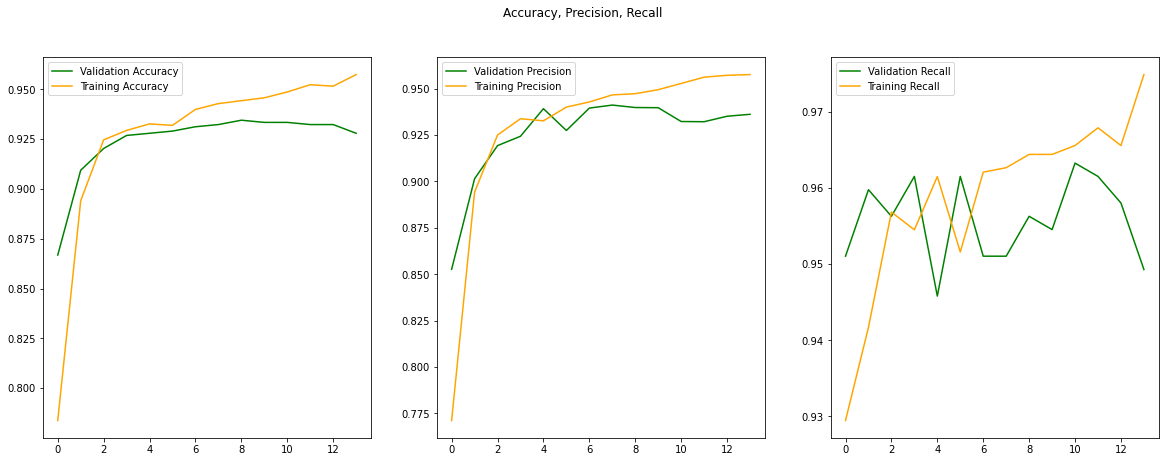

In [69]:
# subplots of accuracy, precision and recall
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols=3, figsize = (20, 7))
fig.suptitle('Accuracy, Precision, Recall')

# axis 1 - accuracy
ax1.plot(history_3_df["val_Accuracy"], label='Validation Accuracy', color='green')
ax1.plot(history_3_df["Accuracy"], label='Training Accuracy', color='orange')
ax1.legend(loc="upper left")
# axis 2 - precision
ax2.plot(history_3_df['val_precision'], label='Validation Precision', color='green')
ax2.plot(history_3_df['precision'], label='Training Precision', color='orange')
ax2.legend(loc="upper left")
# axis3 - recall
ax3.plot(history_3_df['val_recall'], label='Validation Recall', color='green')
ax3.plot(history_3_df['recall'], label='Training Recall', color='orange')
ax3.legend(loc="upper left")

plt.legend();

In [70]:
# evaluate model
model_nn5.evaluate(X_test_sc, y_test, verbose=2)

29/29 - 0s - loss: 1.3800 - Accuracy: 0.8974 - recall: 0.9283 - precision: 0.9092


[1.3799924850463867, 0.8973799347877502, 0.9283216595649719, 0.909246563911438]

In [71]:
# make predictions
y_pred_nn5=model_nn5.predict(X_test_sc)
y_pred_nn5[:10]

array([[9.9920452e-01],
       [9.9992603e-01],
       [1.6882291e-18],
       [1.0000000e+00],
       [8.0451369e-04],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [7.9037433e-16],
       [1.0000000e+00]], dtype=float32)

In [72]:
# round predicted values
y_pred_nn5 =y_pred_nn5.round()
y_pred_nn5[:10]

array([[1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.]], dtype=float32)

In [73]:
# confusion matrix using Tensorflow
tf.math.confusion_matrix(
    y_test, y_pred_nn3
)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[307,  37],
       [ 29, 543]], dtype=int32)>

In [74]:
# classification report
print(classification_report(y_test, y_pred_nn5))

              precision    recall  f1-score   support

           0       0.88      0.85      0.86       344
           1       0.91      0.93      0.92       572

    accuracy                           0.90       916
   macro avg       0.89      0.89      0.89       916
weighted avg       0.90      0.90      0.90       916



In [85]:
# save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_nn5).ravel()
# metrics
accu = (tp+tn) / (tp+tn+fp+fn)
recall = tp/(tp+fn)
prec = tp/ (tp+fp)
spec= tn/(tn+fp)

print('Accuracy:', accu)
print('Recall:', recall)
print('Precision:', prec)
print('Specificity:', spec)

Accuracy: 0.8973799126637555
Recall: 0.9283216783216783
Precision: 0.9092465753424658
Specificity: 0.8459302325581395


### GridSearch with nn

In [75]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [76]:
# X_train.shape

In [77]:
# ss = StandardScaler()
# X_train_sc = ss.fit_transform(X_train)
# X_test_sc = ss.transform(X_test)

In [78]:
# # Add an arugment of number of layers to the function (and loop through it) 
# def model_fn_deep(hidden_neurons, hidden_layers, dropout):
#   model = Sequential()
#   for layer in range(hidden_layers):
#     if layer == 0:
#       model.add(Dense(hidden_neurons, input_shape=(51,), activation='relu'))
#       model.add(Dropout(dropout))
#     else:
#       model.add(Dense(hidden_neurons, activation='relu'))
#       model.add(Dropout(dropout))

#   model.add(Dense(1, activation='sigmoid'))

#   model.compile(loss='bce', optimizer='adam', metrics =['Accuracy','Recall', 'Precision'])

#   return model

# nn_deep = KerasClassifier(build_fn=model_fn_deep, verbose=2)

In [79]:
# nn_params_deep = {
#     'hidden_neurons': [32, 64, 128],
#     'hidden_layers': [2, 3],
#     'dropout': [0.1, 0.2, 0.5],
#     'epochs': [10, 20, 30]
# }

# gs_deep = GridSearchCV(nn_deep, param_grid=nn_params_deep, cv=3, n_jobs=-1)
# gs_deep.fit(X_train_sc, y_train)
# print(gs_deep.best_params_)
# gs_deep.best_score_

In [80]:
# # Make predictions 
# preds_deep = gs_deep.predict(X_test_sc)

In [81]:
# # confusion matrix using Tensorflow
# tf.math.confusion_matrix(
#     y_test, preds_deep
# )

In [82]:
# # classification report
# print(classification_report(y_test, preds_deep))